In [101]:
import numpy as np
from torch.utils.data import IterableDataset
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import xarray as xr
from ocf_blosc2 import Blosc2
from datetime import timezone

import json
from time import sleep
from IPython.display import Video


In [102]:
nonhrv = xr.open_mfdataset(f"/data/climatehack/official_dataset/nonhrv/{2020}/*.zarr.zip", engine="zarr", chunks="auto")
def get_nonhrv_at_time(date):
    year, month = date.year, date.month
    #nonhrv = xr.open_dataset(
        #f"/data/climatehack/official_dataset/nonhrv/{year}/{month}.zarr.zip",
        #engine="zarr",
        #consolidated=True,
    #)
    return nonhrv["data"].sel(time=date).to_numpy()

def month_nonhrv_getter(year, month):
    nonhrv = xr.open_dataset(
        f"/data/climatehack/official_dataset/nonhrv/{year}/{month}.zarr.zip",
        engine="zarr",
        consolidated=True,
    )
    def get_nonhrv_at_time(date):
        return nonhrv["data"].sel(time=date).to_numpy()

    return get_nonhrv_at_time


In [103]:
with open("../indices.json") as f:
	site_locations = {
		data_source: {
			int(site): (int(location[0]), int(location[1]))
			for site, location in locations.items()
                        }
		for data_source, locations in json.load(f).items()
                 }

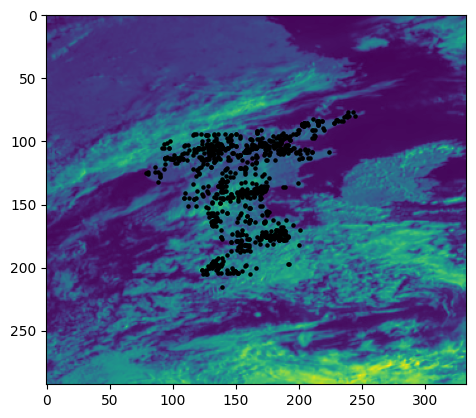

In [104]:
year, month, day, hour, minute = 2020, 7, 19, 18, 0
channel = 8
im = plt.imshow(get_nonhrv_at_time(datetime(year, month, day, hour, minute))[:,:,channel])

site = site_locations["nonhrv"]
x, y = [site[key][0] for key in site], [site[key][1] for key in site]
plt.scatter(x, y, s=5, color="black")
plt.show()

In [107]:
months = [pd.read_parquet(f"/data/climatehack/official_dataset/pv/{2020}/{i}.parquet").drop("generation_wh", axis=1) for i in range(1, 13)]
pv = pd.concat(months)
def get_pv_at_time(date, ss_id=2607, four_hours = False):
    year, month = date.year, date.month
    assert year in [2020, 2021], "year not 2020 or 2021"
    assert minute % 5 == 0, "minute not multiple of 5"
    #pv = pd.read_parquet(f"/data/climatehack/official_dataset/pv/{year}/{month}.parquet").drop("generation_wh", axis=1)

    return pv.loc[date]
    # if four_hours:
    #     id_select = pv.loc[lambda x: x.index.get_level_values("ss_id") == ss_id] 
    #     return id_select.loc[lambda x: (date <= x.index.get_level_values("timestamp")) & (x.index.get_level_values("timestamp") < (date + pd.Timedelta(hours=4)))].to_numpy()
    # else:

def month_pv_getter(year, month):
    pv = pd.read_parquet(f"/data/climatehack/official_dataset/pv/{year}/{month}.parquet").drop("generation_wh", axis=1)
    def get_pv_at_time(date, ss_id = "all"):
        return pv.loc[date]
    return get_pv_at_time


START_DATE = datetime(2020, 5, 5, 6, 0, tzinfo=timezone(timedelta(hours=0)))
pvs = get_pv_at_time(START_DATE, ss_id="all")

In [116]:
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib.animation as animation 
from IPython import display 
  
year, month, day, hour, minute = 2020, 5, 19, 6, 0
START_DATE_PV = datetime(year, month, day, hour, minute, tzinfo=timezone(timedelta(hours=0)))
START_DATE_NONHRV = datetime(year, month, day, hour, minute)
MINUTES_INCR = 15
CHANNEL = 9
get_pv_at_time = month_pv_getter(year, month)
get_nonhrv_at_time = month_nonhrv_getter(year, month)

site = site_locations["nonhrv"]
pvs = get_pv_at_time(START_DATE_PV, ss_id = "all")
x, y = [site[key][0] for key in site if key in pvs.index], [site[key][1] for key in site if key in pvs.index]
c = list(pvs["power"])

fig = plt.figure() 
  
axis = plt.imshow(get_nonhrv_at_time(START_DATE_NONHRV)[:,:,CHANNEL])
#plt.scatter([100], [100], s=50, color="black")
  
#line, = axis.scatter([100], [100], s=20, color="black") 
  
def animate(frame_number): 
    time_delta = timedelta(minutes=MINUTES_INCR * frame_number)
    axis.set_data(get_nonhrv_at_time(START_DATE_NONHRV + time_delta)[:,:,CHANNEL])

    pvs = get_pv_at_time(START_DATE_PV + time_delta, ss_id = "all")
    site_validate = set(pvs.index)
    x, y = [site[key][0] for key in site if key in site_validate], [site[key][1] for key in site if key in site_validate]
    c = np.array(pvs["power"])
    plt.scatter(x, y, s=10, c=c, cmap='inferno')
    return axis, 
  
  
anim = animation.FuncAnimation(fig, animate, frames=60,  
                               interval=100, blit=True) 
  
video = anim.to_html5_video() 
html = display.HTML(video) 
display.display(html) 
plt.close() 
